### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from scipy import signal
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import seaborn as sb
import keras.backend as K
from tensorflow.keras.utils import plot_model
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pydotplus
from pydotplus import graphviz
from sklearn.metrics import classification_report
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential



### Define a list of person numbers and trial numbers

In [2]:
person_numlist = list(range(1, 68))
trials = list(range(1, 4))

### Define fall and ADL types

In [3]:
# Loading ADLs (loading 5 times more adl data then fall, according to proportions)
# Taking 7 adls and 4 falls
# adl_types tells number of windows to extract from each data file

fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
adl_types = {
    'STD':1,
    'WAL':1,
    'JOG':3,
    'JUM':3,
    'STU':6,
    'STN':6,
    'SIT':1
}

In [4]:
# Initialize empty lists to store training data
xtrain = []
ytrain = []

### Loop through ADL types for data loading

In [5]:
total_time = 0

for folder in os.listdir('../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/'):
  if folder not in adl_types : continue
  t1 = time.time()
  
  visualize = 1
  
  path = '../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/' + folder
  print('Reading ADL data from', path, end='')

  for person in person_numlist:
    for trial in trials:
      try :
        # Read data from the file
        data = pd.read_csv(path + '/' + folder + '_' + str(person) + '_' + str(trial) + '_' + 'annotated.csv')

        # Extract features from the data and create windows
        acc_x = np.array(data['acc_x']).reshape((len(data),1))
        acc_y = np.array(data['acc_y']).reshape((len(data),1))
        acc_z = np.array(data['acc_z']).reshape((len(data),1))
        gyro_x = np.array(data['gyro_x']).reshape((len(data),1))
        gyro_y = np.array(data['gyro_y']).reshape((len(data),1))
        gyro_z = np.array(data['gyro_z']).reshape((len(data),1))

        data = np.concatenate([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z],axis = -1)

        num_windows = (9+adl_types[folder])/adl_types[folder]
        for last_point in range(600,len(acc_x)+1,300):
          num_windows -= 1
          xtrain.append(data[last_point-600:last_point])
          ytrain.append(0)
          if num_windows == 0 : break
      except : continue

  t2 = time.time()
  total_time += t2 - t1
  print('Time taken :- ' , t2 - t1)
  plt.show()
print('Time taken == ',total_time)

Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/JOGTime taken :-  1.9868197441101074
Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/JUMTime taken :-  2.006554126739502
Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/SITTime taken :-  0.2990837097167969
Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/STDTime taken :-  3.539013624191284
Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/STNTime taken :-  1.8554542064666748
Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/STUTime taken :-  1.9284477233886719
Reading ADL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/WALTime taken :-  3.7840092182159424
Time taken ==  15.39938235282898


Shape of xtrain after processing ADL data: (4678, 600, 6)


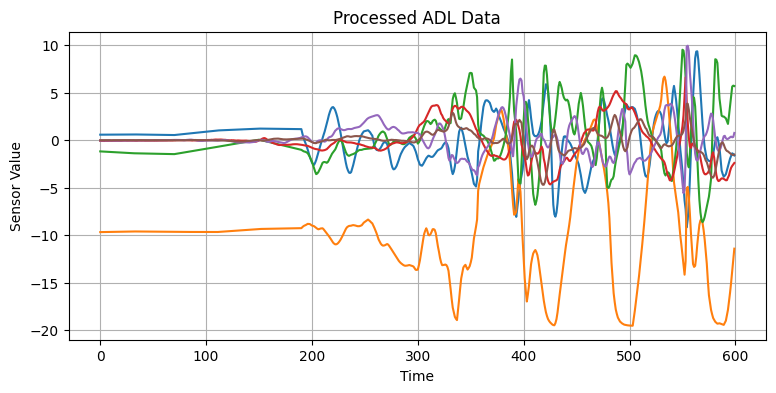

In [6]:
# Print the shape of xtrain after processing ADL data
print(f"Shape of xtrain after processing ADL data: {np.array(xtrain).shape}")

# Plotting the first sample in xtrain after processing ADL data
plt.figure(figsize=(9, 4))
plt.plot(xtrain[0])  # Plotting the first sample
plt.title('Processed ADL Data')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.grid(True)
plt.show()

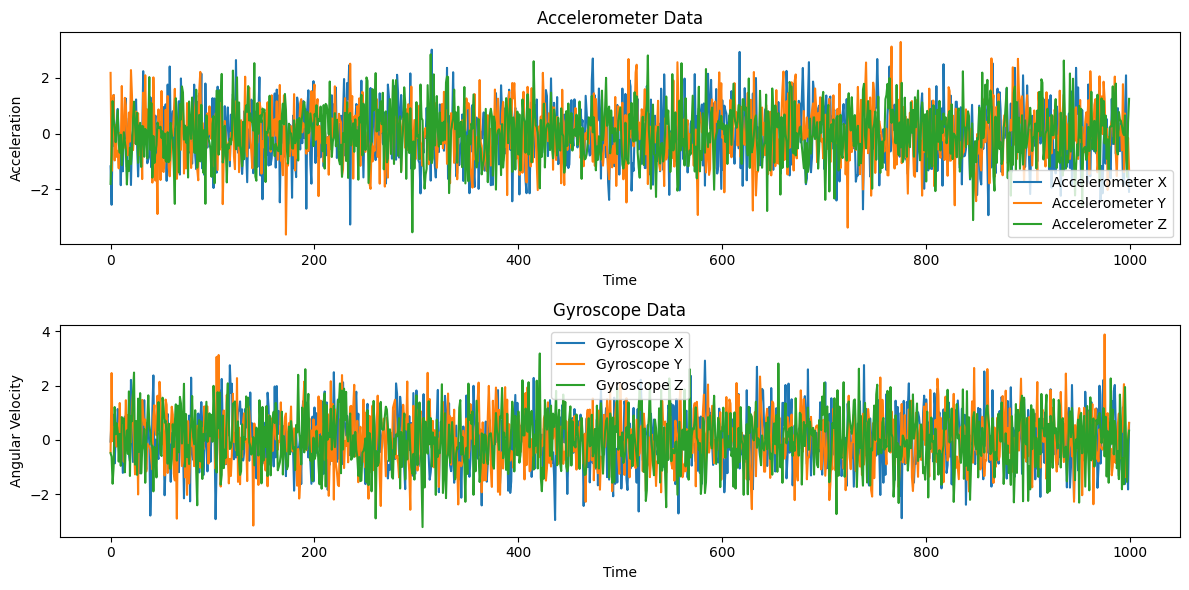

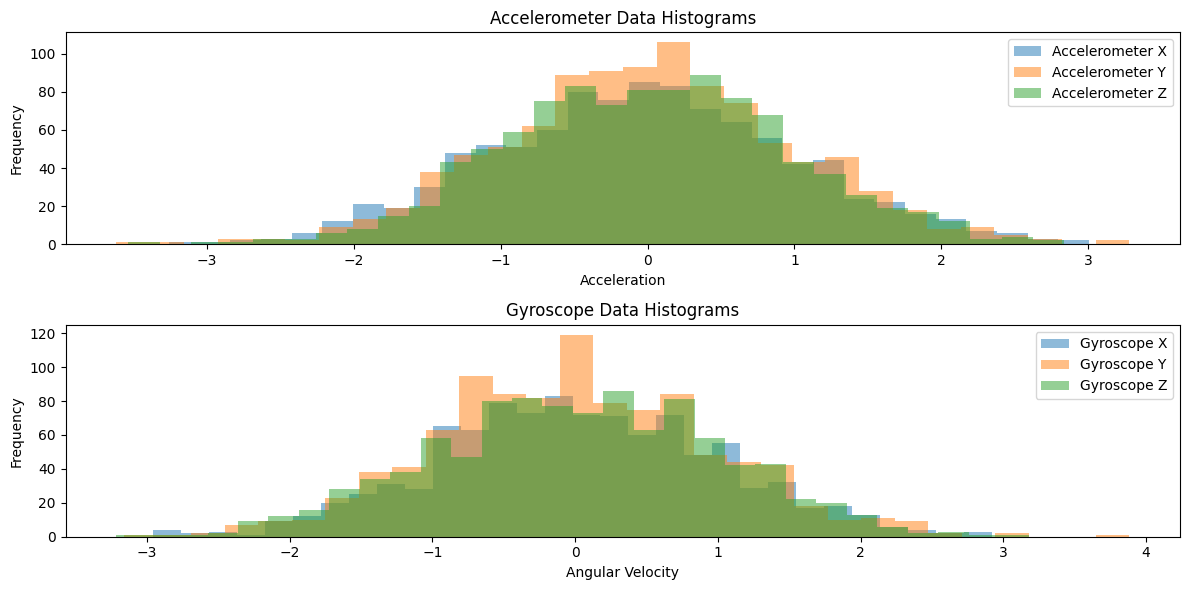

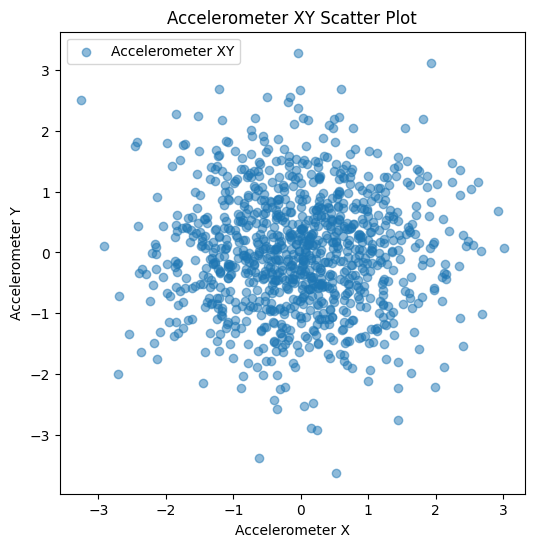

In [7]:
# Generate synthetic accelerometer and gyroscope data
num_samples = 1000
time = np.arange(num_samples)
accel_x = np.random.randn(num_samples)
accel_y = np.random.randn(num_samples)
accel_z = np.random.randn(num_samples)
gyro_x = np.random.randn(num_samples)
gyro_y = np.random.randn(num_samples)
gyro_z = np.random.randn(num_samples)

# Time Series Plots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, accel_x, label='Accelerometer X')
plt.plot(time, accel_y, label='Accelerometer Y')
plt.plot(time, accel_z, label='Accelerometer Z')
plt.title('Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, gyro_x, label='Gyroscope X')
plt.plot(time, gyro_y, label='Gyroscope Y')
plt.plot(time, gyro_z, label='Gyroscope Z')
plt.title('Gyroscope Data')
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.legend()
plt.tight_layout()
plt.show()

# Histograms
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.hist(accel_x, bins=30, alpha=0.5, label='Accelerometer X')
plt.hist(accel_y, bins=30, alpha=0.5, label='Accelerometer Y')
plt.hist(accel_z, bins=30, alpha=0.5, label='Accelerometer Z')
plt.title('Accelerometer Data Histograms')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(gyro_x, bins=30, alpha=0.5, label='Gyroscope X')
plt.hist(gyro_y, bins=30, alpha=0.5, label='Gyroscope Y')
plt.hist(gyro_z, bins=30, alpha=0.5, label='Gyroscope Z')
plt.title('Gyroscope Data Histograms')
plt.xlabel('Angular Velocity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(accel_x, accel_y, label='Accelerometer XY', alpha=0.5)
plt.title('Accelerometer XY Scatter Plot')
plt.xlabel('Accelerometer X')
plt.ylabel('Accelerometer Y')
plt.legend()
plt.show()


### Loop through Fall types for data loading

Reading FALL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/BSCTime taken: 1.9506537914276123
Reading FALL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/FKLTime taken: 2.1013131141662598
Reading FALL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/FOLTime taken: 2.1320266723632812
Reading FALL data from ../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/SDLTime taken: 2.1810848712921143


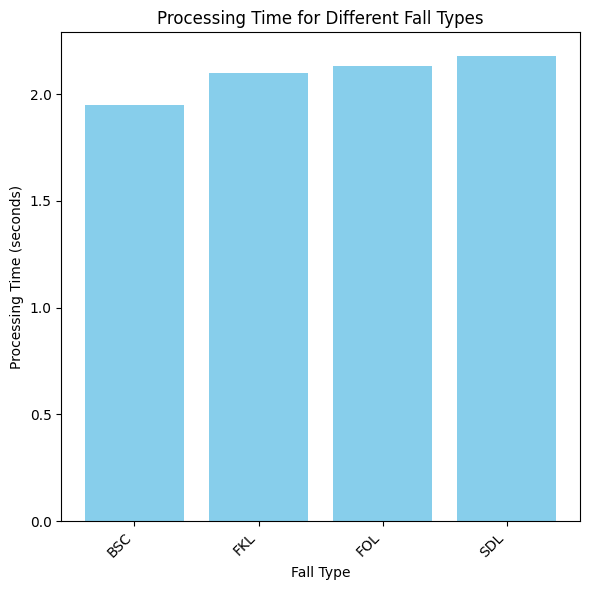

Total time taken: 8.365078449249268


In [8]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import time

# Initialize variables
total_time = 0
fall_processing_times = []

# Iterate over fall data folders
for folder in os.listdir('../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/'):
    if folder not in fall_types:
        continue
    
    # Start timing
    t1 = time.time()
    
    # Process fall data
    visualize = 1
    path = '../MobiAct_Dataset_v2.0/MobiAct_Dataset_v2.0/Annotated Data/' + folder
    print('Reading FALL data from', path, end='')
    
    for person in person_numlist:
        for trial in trials:
            try:
                data = pd.read_csv(path + '/' + folder + '_' + str(person) + '_' + str(trial) + '_' + 'annotated.csv')

                acc_x = np.array(data['acc_x']).reshape((len(data), 1))
                acc_y = np.array(data['acc_y']).reshape((len(data), 1))
                acc_z = np.array(data['acc_z']).reshape((len(data), 1))
                gyro_x = np.array(data['gyro_x']).reshape((len(data), 1))
                gyro_y = np.array(data['gyro_y']).reshape((len(data), 1))
                gyro_z = np.array(data['gyro_z']).reshape((len(data), 1))

                data = np.concatenate([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z], axis=-1)

                acc_x_sd = ((acc_x - np.sum(acc_x) / len(acc_x)) ** 2)
                at = np.argmax(acc_x_sd)
                
                # Extract data around the detected fall event
                if at - 120 >= 0 and at + 480 < len(acc_x):
                    xtrain.append(data[at - 120:at + 480])
                    ytrain.append(1)

                if at - 240 >= 0 and at + 360 < len(acc_x):
                    xtrain.append(data[at - 240:at + 360])
                    ytrain.append(1)

                if at - 360 >= 0 and at + 240 < len(acc_x):
                    xtrain.append(data[at - 360:at + 240])
                    ytrain.append(1)

                if at - 480 >= 0 and at + 120 < len(acc_x):
                    xtrain.append(data[at - 480:at + 120])
                    ytrain.append(1)
                    
            except:
                continue

    # End timing
    t2 = time.time()
    processing_time = t2 - t1
    total_time += processing_time
    
    # Store the processing time for the current fall type
    fall_processing_times.append((folder, processing_time))
    
    print('Time taken:', processing_time)
    
# Plotting the processing times for different fall types
fall_types, times = zip(*fall_processing_times)
plt.figure(figsize=(6, 6))
plt.bar(fall_types, times, color='skyblue')
plt.xlabel('Fall Type')
plt.ylabel('Processing Time (seconds)')
plt.title('Processing Time for Different Fall Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('Total time taken:', total_time)


### Convert lists to numpy arrays

In [9]:
# Convert lists to numpy arrays
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

# Print the shapes of xtrain and ytrain after conversion
print(f"Shape of xtrain after conversion: {xtrain.shape}")
print(f"Shape of ytrain after conversion: {ytrain.shape}")

Shape of xtrain after conversion: (6729, 600, 6)
Shape of ytrain after conversion: (6729,)


### Split the data into training, testing, and validation sets

In [10]:
xtrain,xtest,ytrain,ytest = train_test_split(xtrain,ytrain,train_size = 0.8)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,train_size = 0.5)

In [11]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

# Print the shapes of the datasets
print(f"Shape of xtrain: {xtrain.shape}, ytrain: {ytrain.shape}")
print(f"Shape of xtest: {xtest.shape}, ytest: {ytest.shape}")
print(f"Shape of xval: {xval.shape}, yval: {yval.shape}")

Shape of xtrain: (5383, 600, 6), ytrain: (5383,)
Shape of xtest: (673, 600, 6), ytest: (673,)
Shape of xval: (673, 600, 6), yval: (673,)


### Normalize the data using min-max normalization

In [12]:
# Min-max normalization xtrain ,xval and xtest data

for i in range(6):
    min_ = min([min(j) for j in xtrain[:,:,i]])
    max_ = max([max(j) for j in xtrain[:,:,i]])
    
    xtrain[:,:,i] = 2*(xtrain[:,:,i]-min_)/(max_-min_)-1
    
for i in range(6):
    min_ = min([min(j) for j in xtest[:,:,i]])
    max_ = max([max(j) for j in xtest[:,:,i]])
    
    xtest[:,:,i] = 2*(xtest[:,:,i]-min_)/(max_-min_)-1
    
for i in range(6):
    min_ = min([min(j) for j in xval[:,:,i]])
    max_ = max([max(j) for j in xval[:,:,i]])
    
    xval[:,:,i] = 2*(xval[:,:,i]-min_)/(max_-min_)-1

In [13]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

# Print the shapes of the datasets
print(f"Shape of xtrain: {xtrain.shape}, ytrain: {ytrain.shape}")
print(f"Shape of xtest: {xtest.shape}, ytest: {ytest.shape}")
print(f"Shape of xval: {xval.shape}, yval: {yval.shape}")

Shape of xtrain: (5383, 600, 6), ytrain: (5383,)
Shape of xtest: (673, 600, 6), ytest: (673,)
Shape of xval: (673, 600, 6), yval: (673,)


### Define the LSTM model

In [14]:
# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(64, input_shape=(xtrain.shape[1], xtrain.shape[2])),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xval, yval))




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


169/169 [==============================] - 14s 74ms/step - loss: 0.4750 - accuracy: 0.7620 - val_loss: 0.3710 - val_accuracy: 0.8514
Epoch 2/10
169/169 [==============================] - 12s 71ms/step - loss: 0.2590 - accuracy: 0.8861 - val_loss: 0.2654 - val_accuracy: 0.9183
Epoch 3/10
169/169 [==============================] - 12s 71ms/step - loss: 0.3052 - accuracy: 0.8781 - val_loss: 0.2268 - v

In [34]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(xtest, ytest)
print(f'Test accuracy: {test_acc}')

22/22 [==============================] - 1s 27ms/step - loss: 0.0944 - accuracy: 0.9703
Test accuracy: 0.9702823162078857


In [15]:
from sklearn.metrics import classification_report

# Make predictions
predictions = model.predict(xtest)
# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Calculate classification report
report = classification_report(ytest, binary_predictions, output_dict=True)

# Fill in the table
table = {
    'Batch Size': 32,
    'Accuracy': report['accuracy'],
    'Precision': report['1']['precision'],  # Assuming that '1' is the positive class
    'Recall': report['1']['recall'],
    'F1-Score': report['1']['f1-score'],
    'Test Loss': history.history['val_loss'][-1]  # Last validation loss value
}

# This is the structure of your table filled with values for a batch size of 32
print(table)


22/22 [==============================] - 1s 24ms/step
{'Batch Size': 32, 'Accuracy': 0.9390787518573551, 'Precision': 0.8472906403940886, 'Recall': 0.945054945054945, 'F1-Score': 0.8935064935064934, 'Test Loss': 0.18649323284626007}


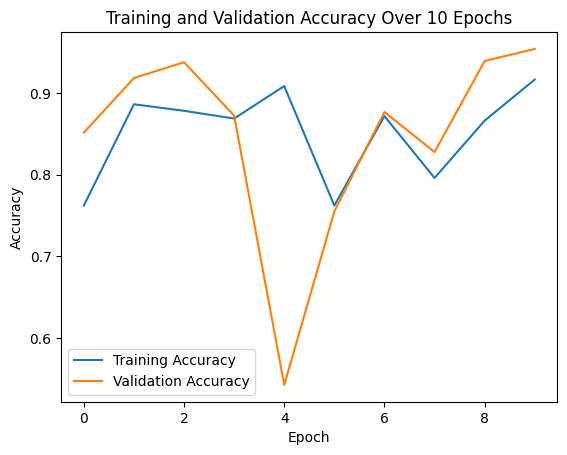

In [16]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over 10 Epochs')
plt.show()

### Model Evaluation and Confusion Matrix

22/22 [==============================] - 1s 23ms/step


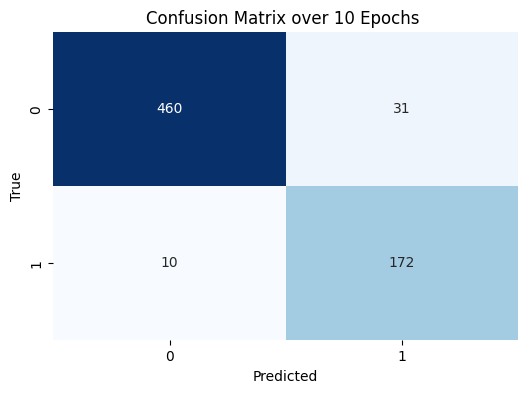

In [17]:

predictions = model.predict(xtest)
binary_predictions = (predictions > 0.5).astype(int)

# Create a confusion matrix
cm = confusion_matrix(ytest, binary_predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix over 10 Epochs ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Multiheaded CNN

In [18]:
# Define the CNN architecture
def build_cnn(input_layer):
  cnn = layers.Conv1D(9,7,padding="same")(input_layer)
  cnn = layers.BatchNormalization()(cnn)
  cnn = layers.Dropout(rate = 0.2)(cnn)
  
  cnn = layers.Conv1D(18,5,padding="same")(cnn)
  cnn = layers.BatchNormalization()(cnn)
  cnn = layers.Dropout(rate = 0.2)(cnn)
  
  cnn = layers.Conv1D(36,3,padding="same")(cnn)
  cnn = layers.BatchNormalization()(cnn)
  cnn = layers.Dropout(rate = 0.2)(cnn)
  
  return cnn

# Bi-LSTM Attentions 

In [19]:
# Define the Bi-LSTM architecture
def build_bilstm(input_layer,last_sequences = False):

  lstm = layers.Bidirectional(layers.LSTM(18,return_sequences = True))(input_layer)
  lstm = layers.LayerNormalization()(lstm)
  lstm = layers.Dropout(rate = 0.2)(lstm)
      
  lstm = layers.Bidirectional(layers.LSTM(36,return_sequences = True))(lstm)
  lstm = layers.LayerNormalization()(lstm)
  lstm = layers.Dropout(rate = 0.2)(lstm)
  
  lstm = layers.Bidirectional(layers.LSTM(72,return_sequences = last_sequences))(lstm)
  lstm = layers.LayerNormalization()(lstm)
  lstm = layers.Dropout(rate = 0.2)(lstm)
  
  return lstm

## Dense layer

In [20]:
# Define the dense layer architecture
def build_dense(input_layer):
    
  dense = layers.Dense(72,name = 'dense_1')(input_layer)
  dense = layers.Dense(1,name = 'dense_3',activation = 'sigmoid')(dense)
  
  return dense

In [21]:
# Define the overall model architecture
def build_model():
    input_layer1 = keras.Input((xtrain.shape[1],3), name = 'Input1')
    input_layer2 = keras.Input((xtrain.shape[1],3), name = 'Input2')
    
    output1 = build_cnn(input_layer1)
    output2 = build_cnn(input_layer2)
    
    output = layers.concatenate([output1,output2])
    
    output = build_bilstm(output)

    output = build_dense(output)
    
    return keras.Model([input_layer1,input_layer2],output)

In [22]:
plot_model(build_model(),show_shapes = True,dpi=40), build_model().summary()

# # Define your model
# model = build_model()

# # Generate the model plot
# plot_model(model, show_shapes=True, dpi=40)
# build_model().summary()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_9 (Conv1D)           (None, 600, 

(None, None)

### Model Compilation and Training

===================================== BATCH_SIZE= 128 learning_rate= 0.0001  =====================================
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_15 (Conv1D)          (None, 600, 9)               198       ['Input2

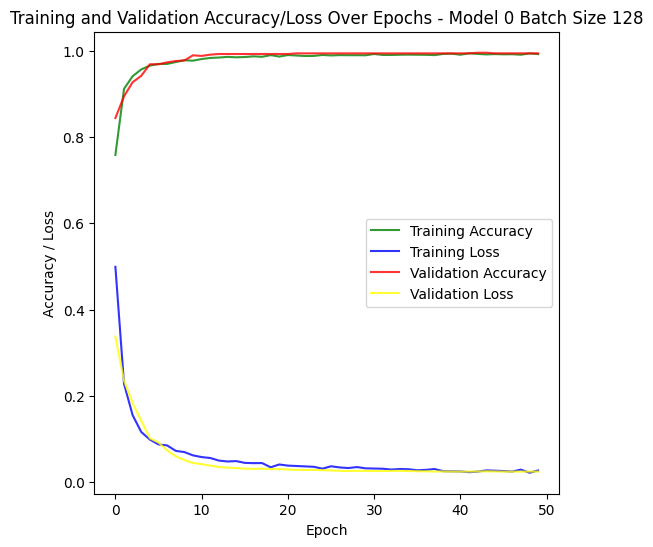

22/22 [==============================] - 1s 64ms/step - loss: 0.0307 - accuracy: 0.9881
Test Loss: 0.030711360275745392, Test Accuracy: 0.9881129264831543
22/22 [==============================] - 3s 63ms/step


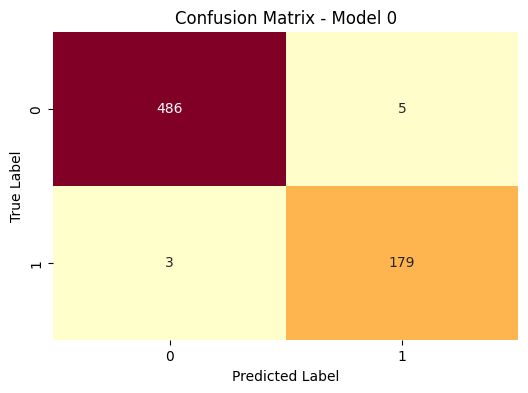

Classification Report - Model 0
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       491
           1       0.97      0.98      0.98       182

    accuracy                           0.99       673
   macro avg       0.98      0.99      0.98       673
weighted avg       0.99      0.99      0.99       673



c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


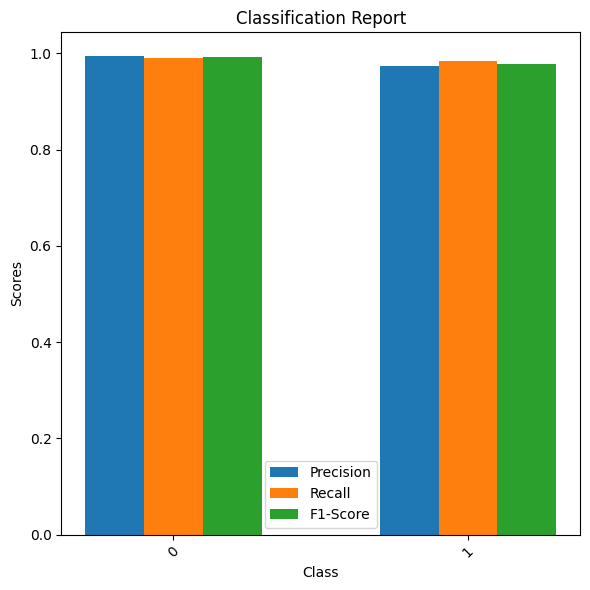

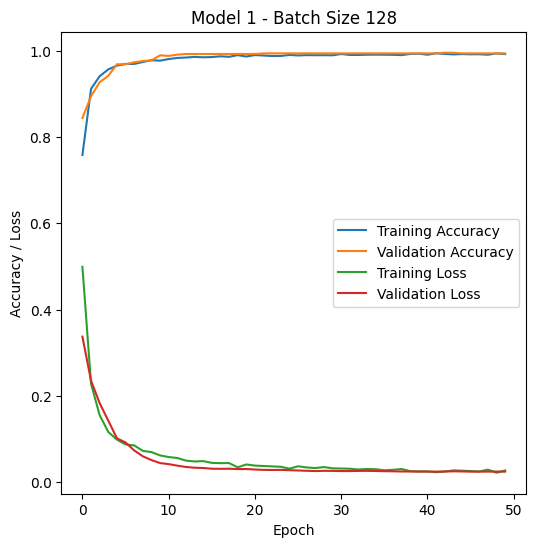

===================================== BATCH_SIZE= 64 learning_rate= 0.0001  =====================================
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_18 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_21 (Conv1D)          (None, 600, 9)               198       ['Input2[

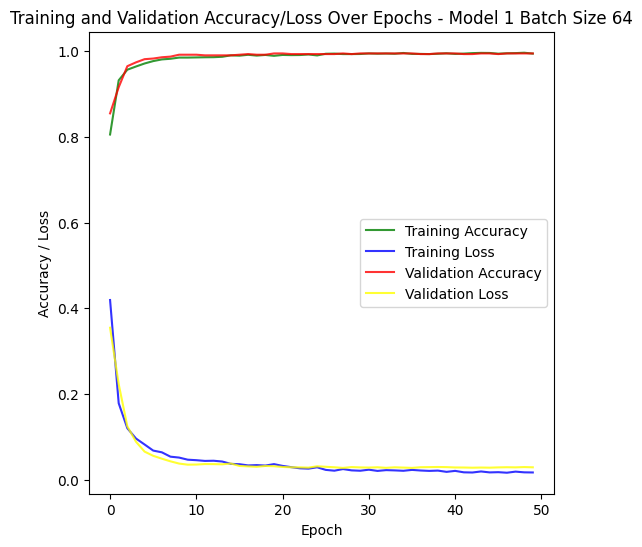

22/22 [==============================] - 1s 67ms/step - loss: 0.0295 - accuracy: 0.9896
Test Loss: 0.029546964913606644, Test Accuracy: 0.98959881067276
22/22 [==============================] - 2s 66ms/step


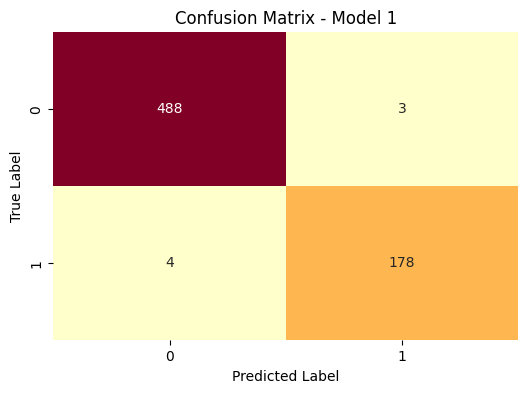

Classification Report - Model 1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       491
           1       0.98      0.98      0.98       182

    accuracy                           0.99       673
   macro avg       0.99      0.99      0.99       673
weighted avg       0.99      0.99      0.99       673



c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


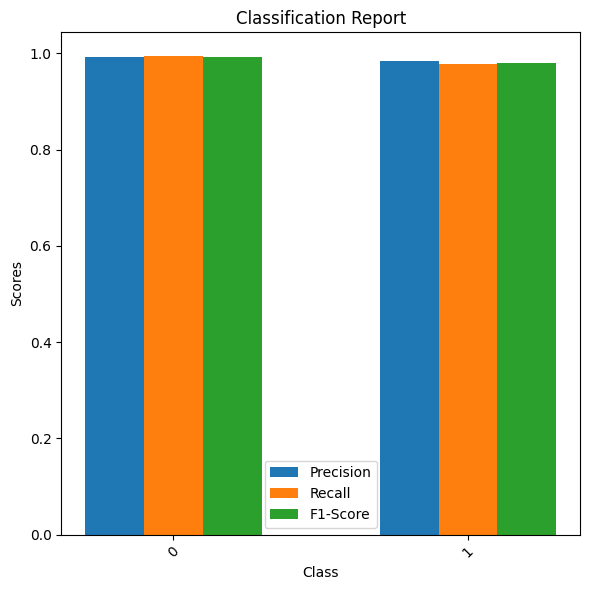

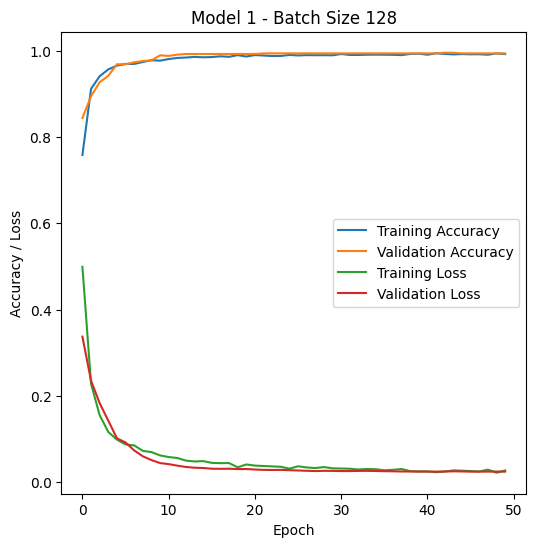

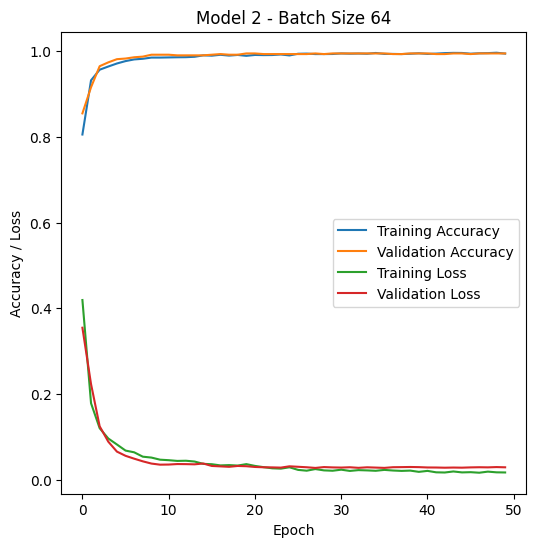

===================================== BATCH_SIZE= 32 learning_rate= 0.0001  =====================================
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_24 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_27 (Conv1D)          (None, 600, 9)               198       ['Input2[

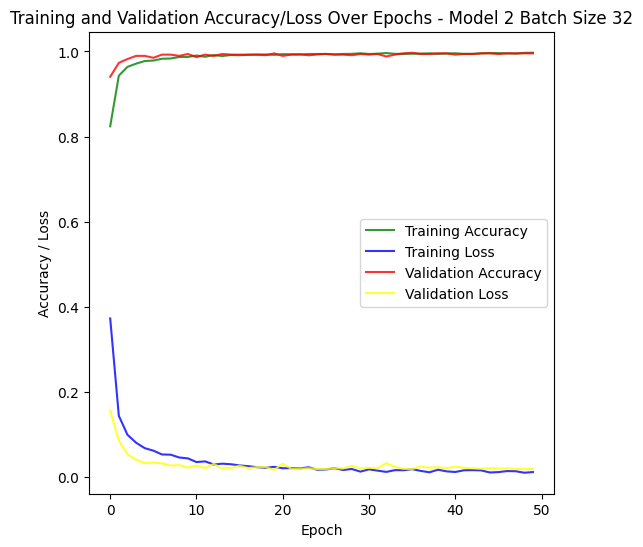

22/22 [==============================] - 2s 67ms/step - loss: 0.0242 - accuracy: 0.9926
Test Loss: 0.024167396128177643, Test Accuracy: 0.9925705790519714
22/22 [==============================] - 3s 67ms/step


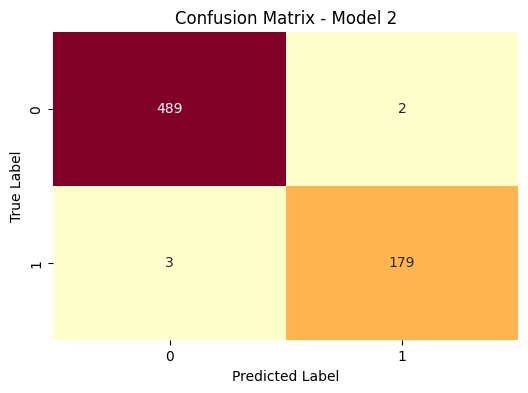

Classification Report - Model 2
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       491
           1       0.99      0.98      0.99       182

    accuracy                           0.99       673
   macro avg       0.99      0.99      0.99       673
weighted avg       0.99      0.99      0.99       673



c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


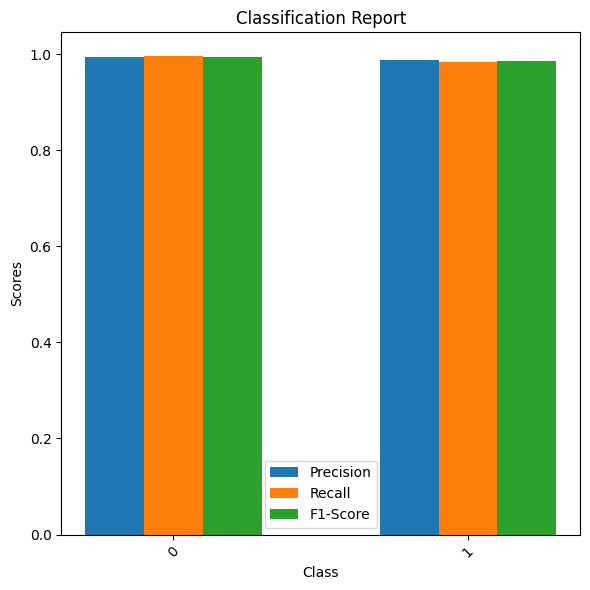

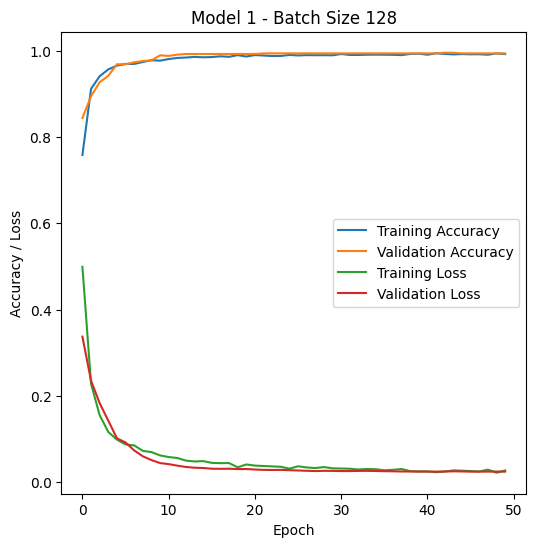

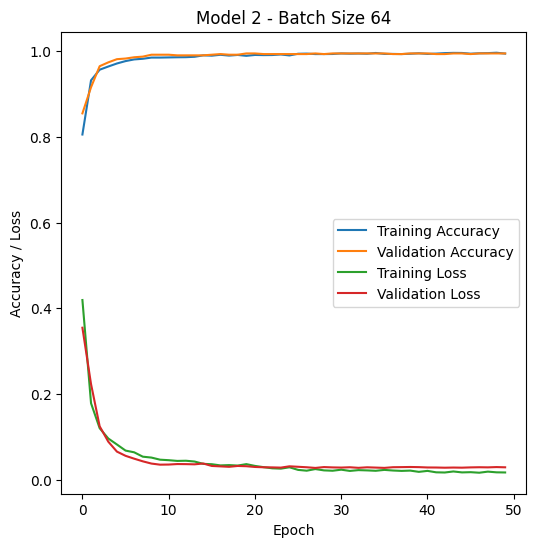

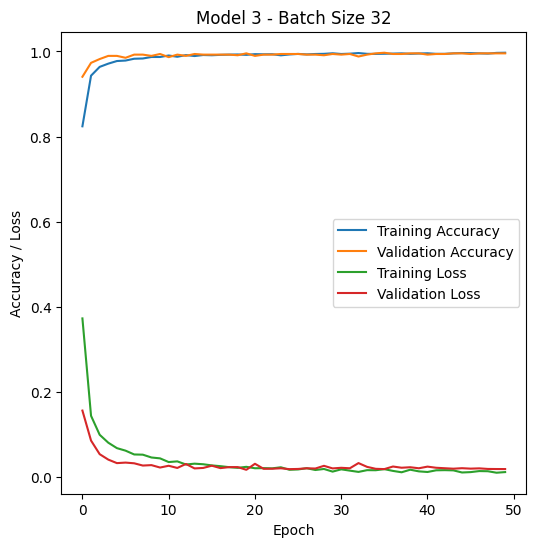

In [23]:
histories = []
model_histories = []
for BATCH_SIZE in [128, 64, 32]:
    for learning_rate in [0.0001]:
        print("\033[1m===================================== BATCH_SIZE=", BATCH_SIZE, "learning_rate=", learning_rate, " =====================================\033[0m")

        # Learning rate scheduler
        lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=int((xtrain.shape[0] + BATCH_SIZE) / BATCH_SIZE),
            decay_rate=0.95
        )

        optimizer = keras.optimizers.Adam()
        optimizer.learning_rate = lr_scheduler

        # Build the model
        model = build_model()

        # Display model summary
        model.summary()

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Reshape the input data to match the model's input shape
        # xtrain_reshaped = xtrain[:, :128, :]
        # xval_reshaped = xval[:, :128, :]
        # xtest_reshaped = xtest[:, :128, :]

        # Modify the input data to match the expected shape of the model's input layer
        xtrain_reshaped = np.pad(xtrain, ((0, 0), (0, 600 - xtrain.shape[1]), (0, 0)), mode='constant')
        xval_reshaped = np.pad(xval, ((0, 0), (0, 600 - xval.shape[1]), (0, 0)), mode='constant')
        xtest_reshaped = np.pad(xtest, ((0, 0), (0, 600 - xtest.shape[1]), (0, 0)), mode='constant')


        # Train the model with reshaped input data
        model_history = model.fit(
            {'Input1': xtrain_reshaped[:, :, 0:3], 'Input2': xtrain_reshaped[:, :, 3:6]},
            ytrain,
            validation_data=(
                [xval_reshaped[:, :, 0:3], xval_reshaped[:, :, 3:6]],
                yval
            ),
            epochs=50,
            batch_size=BATCH_SIZE,
        )

        # Append model to the list
        model_histories.append(model_history)

        # Plotting accuracy and loss
        plt.figure(figsize=(6, 6))
        # Plot training accuracy in green
        plt.plot(model_history.history['accuracy'], color="green", alpha=0.8, label='Training Accuracy')

        # Plot training loss in magenta
        plt.plot(model_history.history['loss'], color="blue", alpha=0.8, label='Training Loss')

        # Plot validation accuracy in cyan
        plt.plot(model_history.history['val_accuracy'], color="red", alpha=0.8, label='Validation Accuracy')

        # Plot validation loss in yellow
        plt.plot(model_history.history['val_loss'], color="yellow", alpha=0.8, label='Validation Loss')

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy / Loss')
        plt.title('Training and Validation Accuracy/Loss Over Epochs - Model ' + str(len(histories)) + ' Batch Size ' + str(BATCH_SIZE))
        plt.legend()
        plt.savefig(str(BATCH_SIZE) + 'bilistm_cnn_Model_Training_Graph.png')  # Specify the path and file name
        plt.show()

        # Evaluate the model on test data
        test_loss, test_accuracy = model.evaluate([xtest_reshaped[:, :, 0:3], xtest_reshaped[:, :, 3:6]], ytest)
        print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

        # Generate predictions on test data
        ypred = model.predict([xtest_reshaped[:, :, 0:3], xtest_reshaped[:, :, 3:6]])

        # Compute confusion matrix
        test_cm = confusion_matrix(ytest, (ypred >= 0.5).astype(int))

        # Visualize confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(test_cm, annot=True, fmt="d", cmap="YlOrRd", cbar=False)
        plt.title("Confusion Matrix - Model " + str(len(histories)))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.savefig(str(BATCH_SIZE) + 'bilistm_cnn_confusion_matrix.png')
        plt.show()

        # Display classification report
        print("Classification Report - Model " + str(len(histories)))
        print(sklearn.metrics.classification_report(ytest, (ypred >= 0.5).astype(int)))

        histories.append(model)
        model.save(str(BATCH_SIZE)+"bilstm_cnn_trained_model.h5")

        # Get classification report
        report = classification_report(ytest, (ypred >= 0.5).astype(int), output_dict=True)

        # Extract precision, recall, and F1-score for each class
        classes = [str(cls) for cls in range(len(report) - 3)]  # Extract class labels
        precision = [report[cls]['precision'] for cls in classes]
        recall = [report[cls]['recall'] for cls in classes]
        f1_score = [report[cls]['f1-score'] for cls in classes]

        # Create bar plot
        x = np.arange(len(classes))
        width = 0.2  # Width of the bars

        fig, ax = plt.subplots(figsize=(6, 6))
        rects1 = ax.bar(x - width, precision, width, label='Precision')
        rects2 = ax.bar(x, recall, width, label='Recall')
        rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

        # Add labels, title, and legend
        ax.set_xlabel('Class')
        ax.set_ylabel('Scores')
        ax.set_title('Classification Report')
        ax.set_xticks(x)
        ax.set_xticklabels(classes)
        ax.legend()

        # Show plot
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show()

        # Now, you can plot the training and validation accuracy/loss using histories list
        for index, history in enumerate(model_histories):
          BATCH_SIZE = [128, 64, 32][index % 3]  # Adjust as needed
          plt.figure(figsize=(6, 6))
          plt.plot(history.history['accuracy'], label='Training Accuracy')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
          plt.plot(history.history['loss'], label='Training Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.title(f'Model {index+1} - Batch Size {BATCH_SIZE}')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy / Loss')
          plt.legend()
          plt.show()

### Saving each trained model

In [ ]:
for index,trained_model in enumerate(histories):
  trained_model.save(str(index)+"bilstm_cnn_trained_model.h5")

In [24]:
class attention(layers.Layer):
    def __init__(self,return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
 
    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),initializer="normal")

        super(attention,self).build(input_shape)
 
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:

            return output
        return K.sum(output, axis=1)

In [25]:
# Multiheaded CNN

def build_cnn(input_layer):
    
    cnn = layers.Conv1D(9,7,padding="same")(input_layer)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(rate = 0.2)(cnn)
    
    cnn = layers.Conv1D(18,5,padding="same")(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(rate = 0.2)(cnn)
    
    cnn = layers.Conv1D(36,3,padding="same")(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(rate = 0.2)(cnn)
    
    return cnn

In [26]:
# Bi-LSTM Attentions 

def build_bilstm(input_layer,last_sequences = False):

    lstm = layers.Bidirectional(layers.LSTM(18,return_sequences = True))(input_layer)
    lstm = layers.LayerNormalization()(lstm)
    lstm = layers.Dropout(rate = 0.2)(lstm)
        
    lstm = attention(True)(lstm)
        
    lstm = layers.Bidirectional(layers.LSTM(36,return_sequences = True))(lstm)
    lstm = layers.LayerNormalization()(lstm)
    lstm = layers.Dropout(rate = 0.2)(lstm)
    
    lstm = attention(True)(lstm)
    
    lstm = layers.Bidirectional(layers.LSTM(72,return_sequences = last_sequences))(lstm)
    lstm = layers.LayerNormalization()(lstm)
    lstm = layers.Dropout(rate = 0.2)(lstm)
    
    return lstm

In [27]:
# Dense layer

def build_dense(input_layer):
    
    dense = layers.Dense(72,name = 'dense_1')(input_layer)
    dense = layers.Dense(1,name = 'dense_3',activation = 'sigmoid')(dense)
    
    return dense

In [28]:
def build_model():
    input_layer1 = keras.Input((xtrain.shape[1],3), name = 'Input1')
    input_layer2 = keras.Input((xtrain.shape[1],3), name = 'Input2')
    
    output1 = build_cnn(input_layer1)
    output2 = build_cnn(input_layer2)
    
    output = layers.concatenate([output1,output2])
    
    output = build_bilstm(output)

    output = build_dense(output)
    
    return keras.Model([input_layer1,input_layer2],output)

In [50]:
plot_model(build_model(),show_shapes = True,dpi=40),build_model().summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_39 (Conv1D)          (None, 600, 9

(None, None)

=====================================BATCH_SIZE= 128 learning_rate= 0.0001 =====================================
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_30 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                            

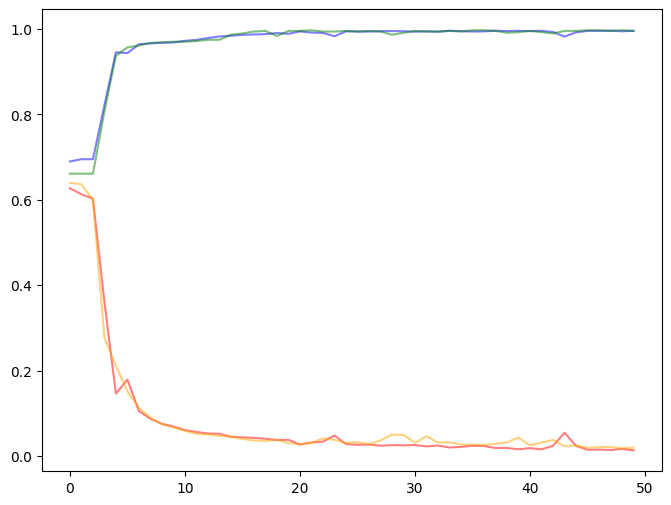

22/22 [==============================] - 2s 108ms/step - loss: 0.0249 - accuracy: 0.9911
test loss =  0.02491983212530613
22/22 [==============================] - 2s 107ms/step - loss: 0.0249 - accuracy: 0.9911
test accuracy =  0.9910846948623657 

22/22 [==============================] - 3s 107ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       491
           1       0.99      0.97      0.98       182

    accuracy                           0.99       673
   macro avg       0.99      0.99      0.99       673
weighted avg       0.99      0.99      0.99       673

=====================================BATCH_SIZE= 64 learning_rate= 0.0001 =====================================


c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_39 (Conv1D)          (None, 600, 9

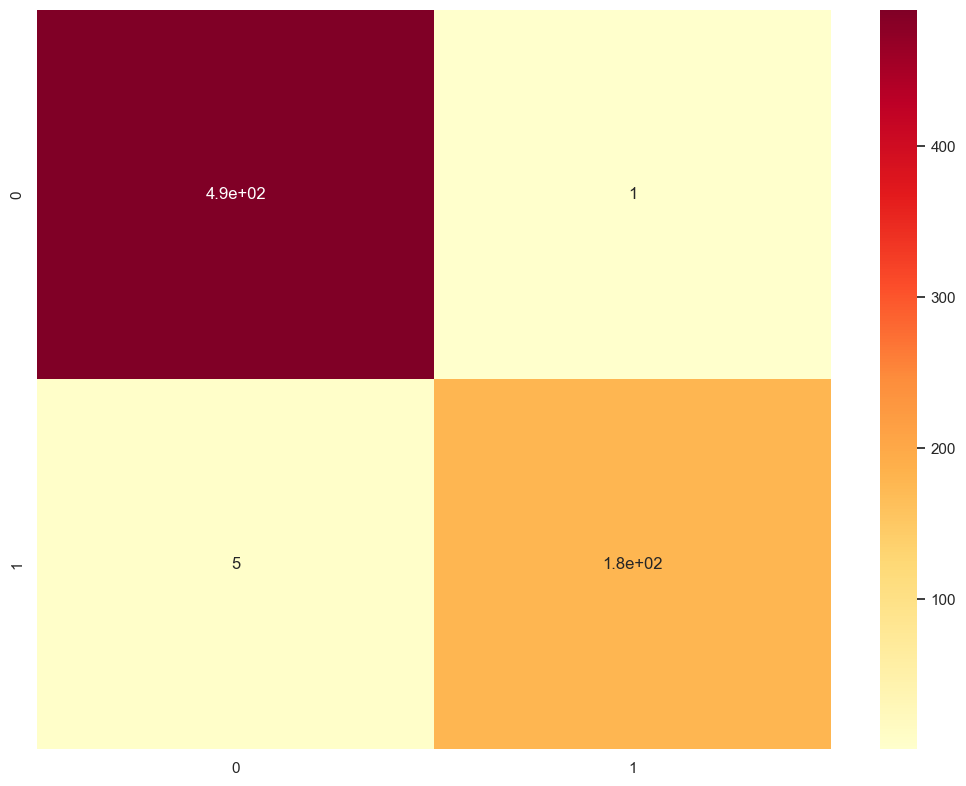

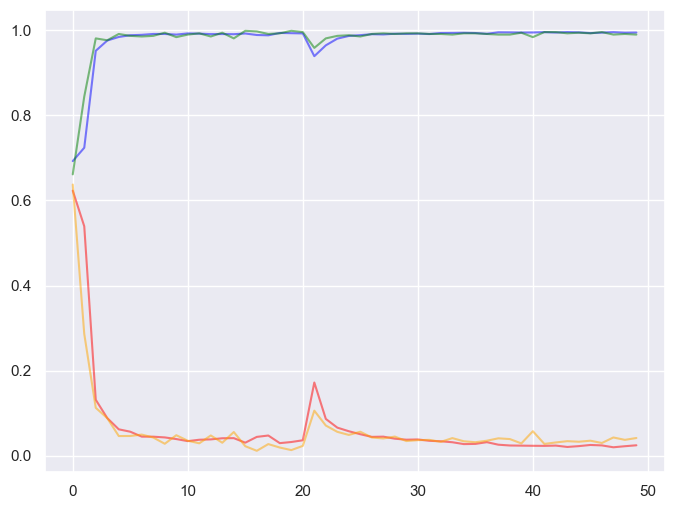

22/22 [==============================] - 6s 257ms/step - loss: 0.0367 - accuracy: 0.9881
test loss =  0.03670786693692207
22/22 [==============================] - 6s 257ms/step - loss: 0.0367 - accuracy: 0.9881
test accuracy =  0.9881129264831543 

22/22 [==============================] - 7s 256ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       491
           1       0.99      0.97      0.98       182

    accuracy                           0.99       673
   macro avg       0.99      0.98      0.98       673
weighted avg       0.99      0.99      0.99       673

=====================================BATCH_SIZE= 32 learning_rate= 0.0001 =====================================


c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input1 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 Input2 (InputLayer)         [(None, 600, 3)]             0         []                            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 600, 9)               198       ['Input1[0][0]']              
                                                                                                  
 conv1d_45 (Conv1D)          (None, 600, 9

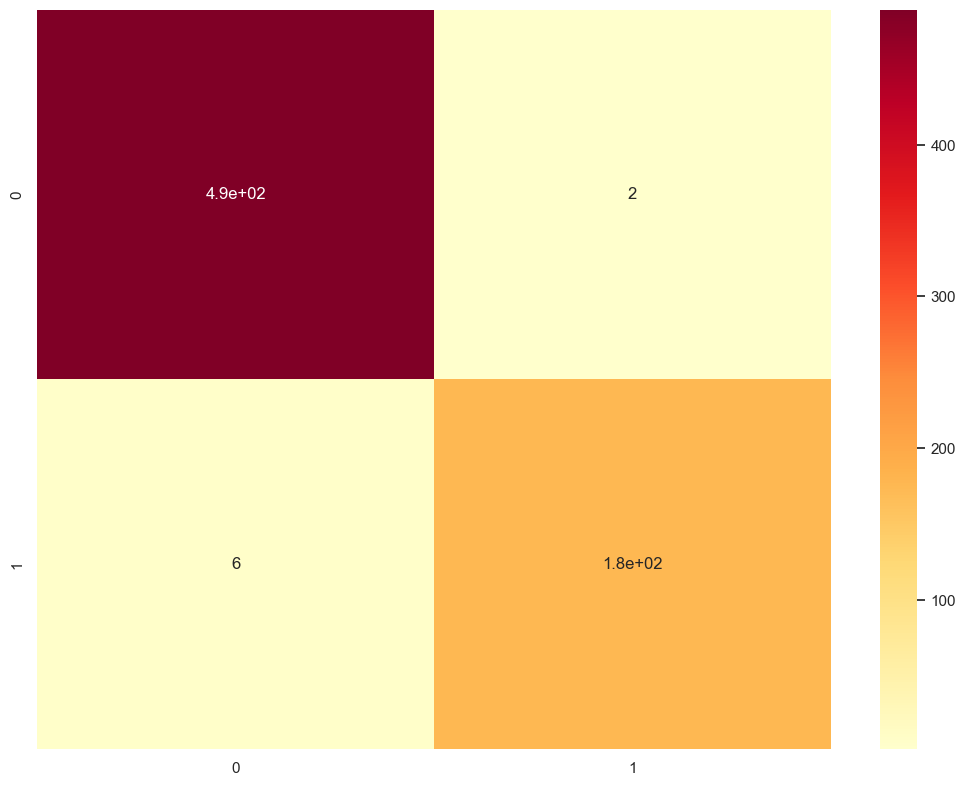

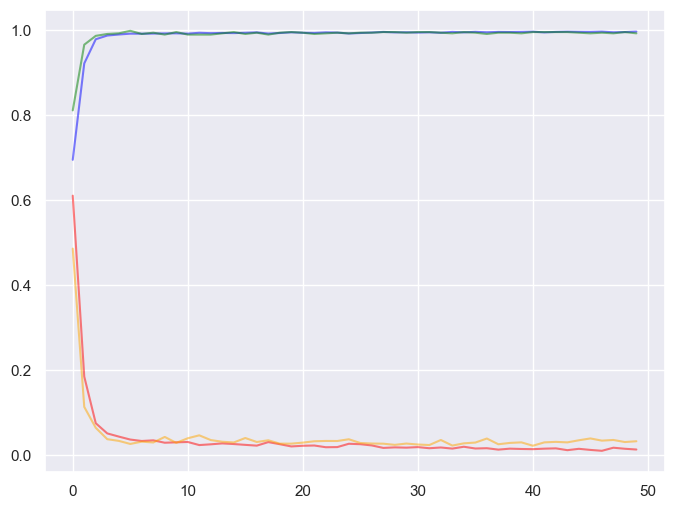

22/22 [==============================] - 4s 180ms/step - loss: 0.0192 - accuracy: 0.9911
test loss =  0.019184008240699768
22/22 [==============================] - 4s 163ms/step - loss: 0.0192 - accuracy: 0.9911
test accuracy =  0.9910846948623657 

22/22 [==============================] - 5s 168ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       491
           1       0.98      0.98      0.98       182

    accuracy                           0.99       673
   macro avg       0.99      0.99      0.99       673
weighted avg       0.99      0.99      0.99       673



c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


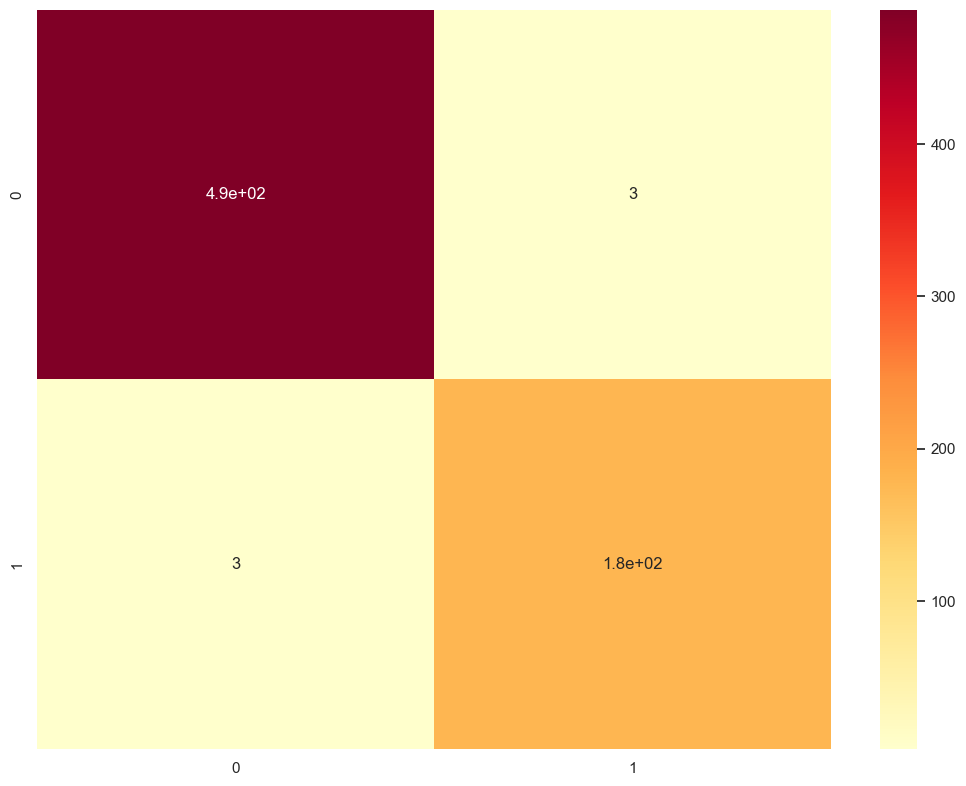

In [29]:
models_with_attention = []

for BATCH_SIZE in [128,64,32]:
    for learning_rate in [0.0001]:
        print("\033[1m=====================================BATCH_SIZE=",BATCH_SIZE,"learning_rate=",learning_rate,"=====================================\033[0m")

        lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = learning_rate,
            decay_steps = int((xtrain.shape[0] + BATCH_SIZE)/BATCH_SIZE),
            decay_rate = 0.99
        )
        
        optimizer = keras.optimizers.Adam()
        optimizer.learning_rate = lr_scheduler
        
        model = build_model()

        plot_model(model,show_shapes = True,dpi=20)

        model.summary()

        model.compile(loss = 'binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        model_history = model.fit(
            {'Input1': xtrain[:,:,0:3], 'Input2': xtrain[:,:,3:6]},
            ytrain,
            validation_data = (
                [xval[:,:,0:3],xval[:,:,3:6]],
                yval
            ),
            epochs = 50,
            batch_size = BATCH_SIZE,
        )

        # Testing accuracy

        plt.figure(figsize = (8,6))
        plt.plot(model_history.history['accuracy'], color="blue", alpha = 0.5)
        plt.plot(model_history.history['loss'], color="red", alpha = 0.5)
        plt.plot(model_history.history['val_accuracy'], color="green", alpha = 0.5)
        plt.plot(model_history.history['val_loss'], color="orange", alpha = 0.5)
        plt.savefig(str(BATCH_SIZE) + 'bilistm_cnn_attentions_Model_Training_Graph.png')
        plt.show()

        print('test loss = ',model.evaluate([xtest[:,:,0:3],xtest[:,:,3:6]], ytest)[0])      
        print('test accuracy = ',model.evaluate([xtest[:,:,0:3],xtest[:,:,3:6]], ytest)[1],'\n')

        ypred = model.predict([xtest[:,:,0:3],xtest[:,:,3:6]])

        test_cm = confusion_matrix(ytest,(ypred >= 0.5)*1)

        sb.set(rc = {'figure.figsize':(12.8,9.6)})
        sb.heatmap(test_cm,annot = True, cmap = 'YlOrRd')
        plt.plot()
        
        print(sklearn.metrics.classification_report(ytest,(ypred >= 0.5)*1))

        models_with_attention.append(model)
        model.save(str(BATCH_SIZE)+"bilstm_cnn_attentions_trained_model.h5")

In [52]:
import pickle
pickle.dump(histories, open('models_multiheadedcnn_biLSTM.sav', 'wb'))
pickle.dump(models_with_attention, open('models_multiheadedcnn_biLSTM_with_attention.sav', 'wb'))
pickle.dump(xtrain, open('xtrain.sav', 'wb'))
pickle.dump(xtest, open('xtest.sav', 'wb'))
pickle.dump(xval, open('xval.sav', 'wb'))
pickle.dump(ytrain, open('ytrain.sav', 'wb'))
pickle.dump(ytest, open('ytest.sav', 'wb'))
pickle.dump(yval, open('yval.sav', 'wb'))

In [30]:
def build_gru_model(input_shape):
    model = Sequential([
        GRU(256, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        GRU(128, return_sequences=True),
        Dropout(0.5),
        GRU(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model


===================================== BATCH_SIZE=128, learning_rate=0.0001 =====================================
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 600, 256)          202752    
                                                                 
 batch_normalization_48 (Ba  (None, 600, 256)          1024      
 tchNormalization)                                               
                                                                 
 gru_1 (GRU)                 (None, 600, 128)          148224    
                                                                 
 dropout_72 (Dropout)        (None, 600, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dropou

c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


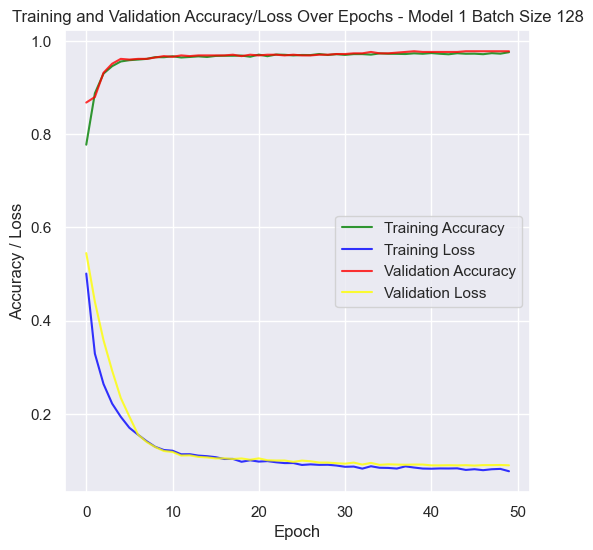

22/22 [==============================] - 13s 591ms/step - loss: 0.1287 - accuracy: 0.9599
Test Loss: 0.128731369972229, Test Accuracy: 0.9598811268806458
22/22 [==============================] - 14s 588ms/step


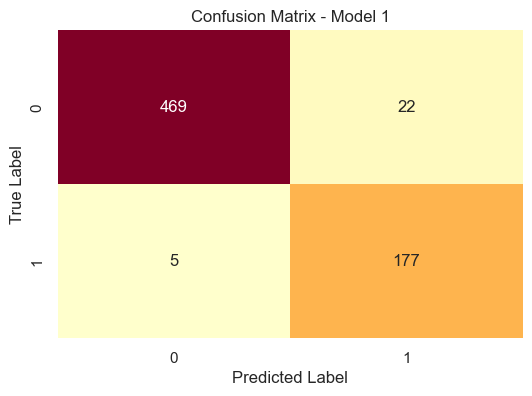

Classification Report - Model 1
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       491
           1       0.89      0.97      0.93       182

    accuracy                           0.96       673
   macro avg       0.94      0.96      0.95       673
weighted avg       0.96      0.96      0.96       673



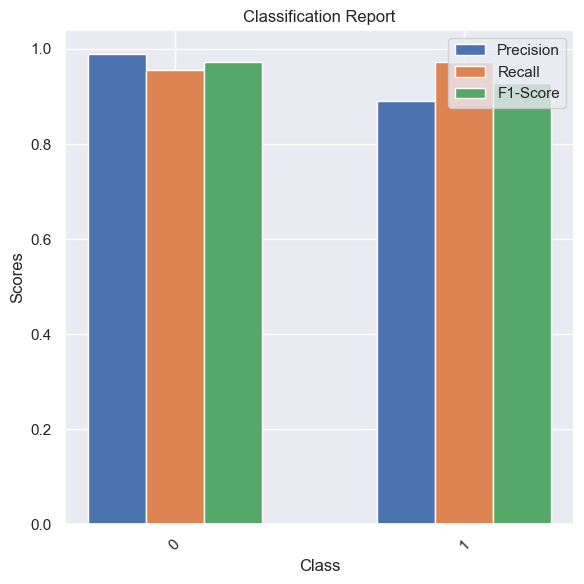

===================================== BATCH_SIZE=64, learning_rate=0.0001 =====================================
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 600, 256)          202752    
                                                                 
 batch_normalization_49 (Ba  (None, 600, 256)          1024      
 tchNormalization)                                               
                                                                 
 gru_4 (GRU)                 (None, 600, 128)          148224    
                                                                 
 dropout_74 (Dropout)        (None, 600, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout

c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


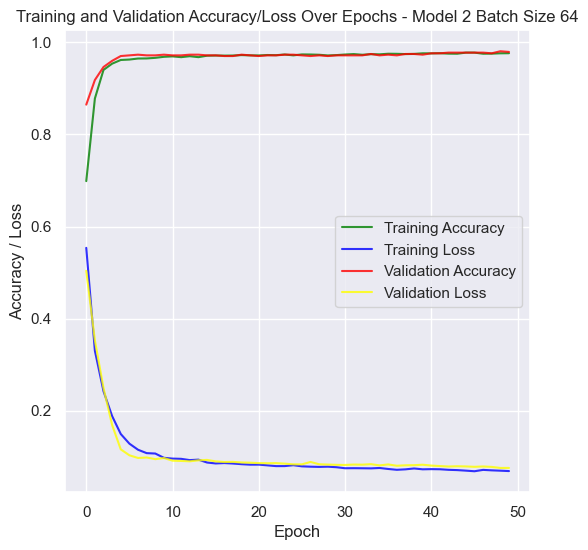

22/22 [==============================] - 8s 384ms/step - loss: 0.1161 - accuracy: 0.9614
Test Loss: 0.11608950048685074, Test Accuracy: 0.9613670110702515
22/22 [==============================] - 9s 391ms/step


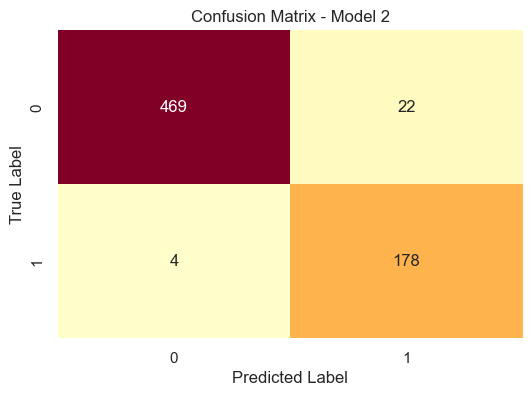

Classification Report - Model 2
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       491
           1       0.89      0.98      0.93       182

    accuracy                           0.96       673
   macro avg       0.94      0.97      0.95       673
weighted avg       0.96      0.96      0.96       673



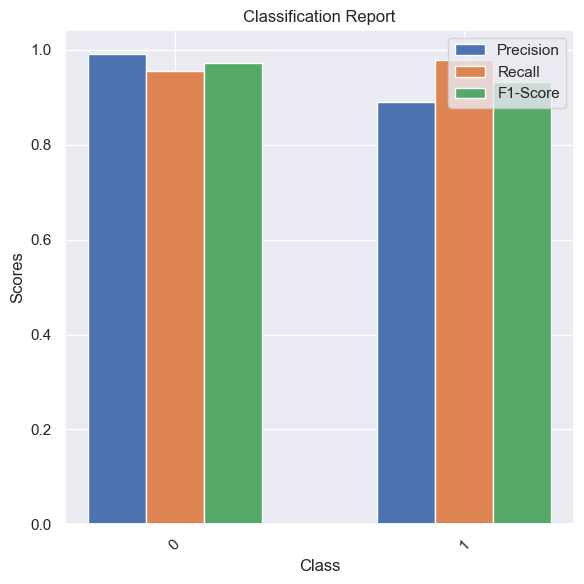

===================================== BATCH_SIZE=32, learning_rate=0.0001 =====================================
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 600, 256)          202752    
                                                                 
 batch_normalization_50 (Ba  (None, 600, 256)          1024      
 tchNormalization)                                               
                                                                 
 gru_7 (GRU)                 (None, 600, 128)          148224    
                                                                 
 dropout_76 (Dropout)        (None, 600, 128)          0         
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dropout

c:\Users\yashs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


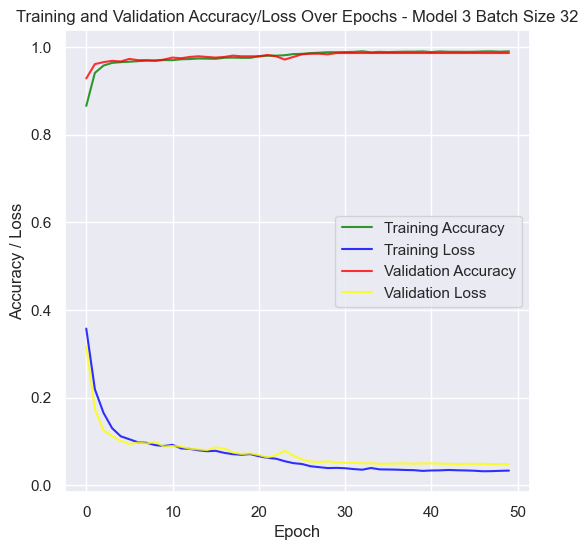

22/22 [==============================] - 8s 384ms/step - loss: 0.0557 - accuracy: 0.9837
Test Loss: 0.055696744471788406, Test Accuracy: 0.9836552739143372
22/22 [==============================] - 9s 384ms/step


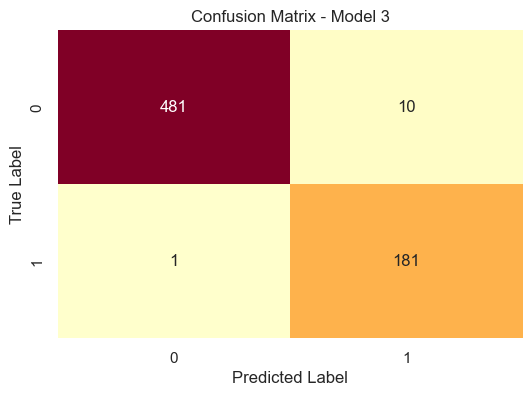

Classification Report - Model 3
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       491
           1       0.95      0.99      0.97       182

    accuracy                           0.98       673
   macro avg       0.97      0.99      0.98       673
weighted avg       0.98      0.98      0.98       673



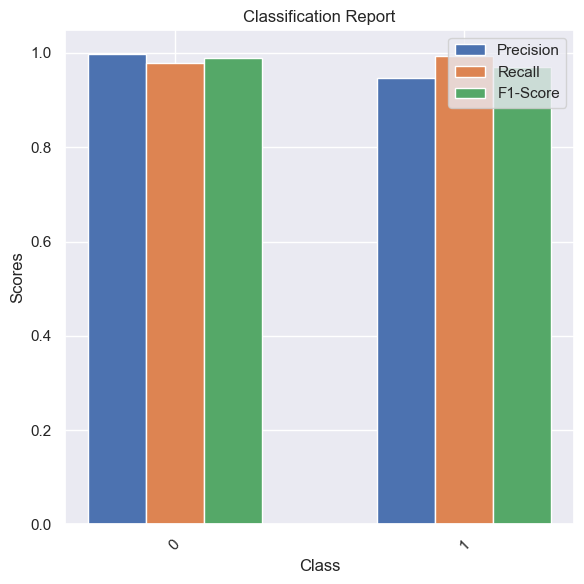

In [31]:
gru_models = []
gru_model_histories = []
for BATCH_SIZE in [128, 64, 32]:
  for learning_rate in [0.0001]:
    print(f"===================================== BATCH_SIZE={BATCH_SIZE}, learning_rate={learning_rate} =====================================")

    # Learning rate scheduler
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=int((xtrain.shape[0] + BATCH_SIZE) / BATCH_SIZE),
        decay_rate=0.95
    )

    optimizer = keras.optimizers.Adam()
    optimizer.learning_rate = lr_scheduler

    # Build the model
    model = build_gru_model((600, 6))  # Assuming xtrain reshaped to (None, 600, 6)

    # Display model summary
    model.summary()

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    xtrain_reshaped = scaler.fit_transform(xtrain.reshape(-1, xtrain.shape[2])).reshape(xtrain.shape)
    xval_reshaped = scaler.transform(xval.reshape(-1, xval.shape[2])).reshape(xval.shape)
    xtest_reshaped = scaler.transform(xtest.reshape(-1, xtest.shape[2])).reshape(xtest.shape)

    # # Reshape the input data to match the model's input shape
    # xtrain_reshaped = np.pad(xtrain, ((0, 0), (0, 600 - xtrain.shape[1]), (0, 0)), mode='constant')
    # xval_reshaped = np.pad(xval, ((0, 0), (0, 600 - xval.shape[1]), (0, 0)), mode='constant')
    # xtest_reshaped = np.pad(xtest, ((0, 0), (0, 600 - xtest.shape[1]), (0, 0)), mode='constant')

    # Train the model with reshaped input data
    model_history = model.fit(
        xtrain_reshaped,
        ytrain,
        validation_data=(xval_reshaped, yval),
        epochs=50,
        batch_size=BATCH_SIZE
    )
    gru_model_histories.append(model_history)
    gru_models.append(model)
    model.save(str(BATCH_SIZE)+"gru_trained_model.h5")

    # Plotting accuracy and loss
    plt.figure(figsize=(6, 6))
    plt.plot(model_history.history['accuracy'], color="green", alpha=0.8, label='Training Accuracy')
    plt.plot(model_history.history['loss'], color="blue", alpha=0.8, label='Training Loss')
    plt.plot(model_history.history['val_accuracy'], color="red", alpha=0.8, label='Validation Accuracy')
    plt.plot(model_history.history['val_loss'], color="yellow", alpha=0.8, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.title(f'Training and Validation Accuracy/Loss Over Epochs - Model {len(gru_models)} Batch Size {BATCH_SIZE}')
    plt.legend()
    plt.savefig(str(BATCH_SIZE) + 'gru_Model_Training_Graph.png')
    plt.show()

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(xtest_reshaped, ytest)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

    # Generate predictions on test data
    ypred = model.predict(xtest_reshaped)

    # Compute confusion matrix
    test_cm = confusion_matrix(ytest, (ypred >= 0.5).astype(int))

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="YlOrRd", cbar=False)
    plt.title("Confusion Matrix - Model " + str(len(gru_models)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(str(BATCH_SIZE) + 'gru_Model_Confusion_Matrix.png')
    plt.show()

    # Display classification report
    print("Classification Report - Model " + str(len(gru_models)))
    print(classification_report(ytest, (ypred >= 0.5).astype(int)))

    # Get classification report
    report = classification_report(ytest, (ypred >= 0.5).astype(int), output_dict=True)

    # Extract precision, recall, and F1-score for each class
    classes = [str(cls) for cls in range(len(report) - 3)]  # Extract class labels
    precision = [report[cls]['precision'] for cls in classes]
    recall = [report[cls]['recall'] for cls in classes]
    f1_score = [report[cls]['f1-score'] for cls in classes]

    # Create bar plot
    x = np.arange(len(classes))
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(6, 6))
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

    # Add labels, title, and legend
    ax.set_xlabel('Class')
    ax.set_ylabel('Scores')
    ax.set_title('Classification Report')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Show plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

In [ ]:
for index, gru_model in enumerate(gru_models):
  BATCH_SIZE = [128, 64, 32][index % 3]  # Adjust as needed
  plt.figure(figsize=(6, 6))
  plt.plot(gru_model.history['accuracy'], label='Training Accuracy')
  plt.plot(gru_model.history['val_accuracy'], label='Validation Accuracy')
  plt.plot(gru_model.history['loss'], label='Training Loss')
  plt.plot(gru_model.history['val_loss'], label='Validation Loss')
  plt.title(f'Model {index+1} - Batch Size {BATCH_SIZE}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy / Loss')
  plt.legend()
  plt.show()

In [ ]:
for index,trained_model in enumerate(model_histories):
  trained_model.save(str(index)+"gru_trained_model.keras")